In [239]:
# Importing Libraries

In [415]:
import pandas as pd
import numpy as np

In [416]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
   
    4: 'SITTING',#1
    5: 'STANDING',
    6: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [453]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Data

In [454]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [455]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [456]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(np.array(_read_csv(filename))) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [457]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return np.array(pd.get_dummies(y))

def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [458]:
# Importing tensorflow
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.compat.v1.set_random_seed(42)

In [459]:
# Configuring a session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [460]:
# Import Keras
from keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


In [461]:
# Importing libraries

from keras.models import Sequential
from keras.layers import LSTM,MaxPooling1D,Flatten,BatchNormalization
from keras.layers.core import Dense, Dropout

In [462]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D

In [463]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [464]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [465]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [466]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [214]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [23]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 92s 13ms/step - loss: 1.3018 - acc: 0.4395 - val_loss: 1.1254 - val_acc: 0.4662
Epoch 2/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.9666 - acc: 0.5880 - val_loss: 0.9491 - val_acc: 0.5714
Epoch 3/30
7352/7352 [==============================] - 97s 13ms/step - loss: 0.7812 - acc: 0.6408 - val_loss: 0.8286 - val_acc: 0.5850
Epoch 4/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.6941 - acc: 0.6574 - val_loss: 0.7297 - val_acc: 0.6128
Epoch 5/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.6336 - acc: 0.6912 - val_loss: 0.7359 - val_acc: 0.6787
Epoch 6/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.5859 - acc: 0.7134 - val_loss: 0.7015 - val_acc: 0.6939
Epoch 7/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.5692 - acc: 0.7477 - val_loss: 0.5995 - val_acc: 0.7387


In [24]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [27]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 2ms/step


In [28]:
score

[0.3087582236972612, 0.9097387173396675]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

#Just changing dropout and layers of Lstm

In [487]:
# Initializing parameters
tf.keras.backend.clear_session()
epochs = 30
batch_size = 16
n_hidden = 25

In [233]:
# Initiliazing the sequential model
#n_hidden=25,dropout=0.275
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.275))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                3500      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 156       
Total params: 3,656
Trainable params: 3,656
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [235]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Epoch 1/30
460/460 [==============================] - 6s 13ms/step - loss: 1.3714 - accuracy: 0.4138 - val_loss: 1.2028 - val_accuracy: 0.4496
Epoch 2/30
460/460 [==============================] - 5s 12ms/step - loss: 1.0548 - accuracy: 0.5487 - val_loss: 1.0137 - val_accuracy: 0.5307
Epoch 3/30
460/460 [==============================] - 5s 12ms/step - loss: 0.8974 - accuracy: 0.6185 - val_loss: 0.8855 - val_accuracy: 0.5969
Epoch 4/30
460/460 [==============================] - 5s 12ms/step - loss: 0.7789 - accuracy: 0.6692 - val_loss: 0.7431 - val_accuracy: 0.7000
Epoch 5/30
460/460 [==============================] - 6s 12ms/step - loss: 0.7090 - accuracy: 0.6876 - val_loss: 0.7831 - val_accuracy: 0.6569
Epoch 6/30
460/460 [==============================] - 6s 12ms/step - loss: 0.6622 - accuracy: 0.7085 - val_loss: 0.6781 - val_accuracy: 0.7146
Epoch 7/30
460/460 [==============================] - 6s 12ms/step - loss: 0.5510 - accuracy: 0.7652 - val_loss: 0.5785 - val_accuracy: 0.7401

In [238]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  2      400        64        1                   0   
STANDING                 0       96       430        6                   0   
WALKING                  0        0         0      480                  15   
WALKING_DOWNSTAIRS       0        0         0        0                 416   
WALKING_UPSTAIRS         0        1         0        9                   8   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                           24  
STANDING                           0  
WALKING                            1  
WALKING_DOWNSTAIRS                 4  
WALKING_UPSTAIRS                 453  


In [236]:
min(model.history.history['val_loss'])

0.22888034582138062

In [237]:
max(model.history.history['val_accuracy'])

0.922633171081543

#tried single layer 2 with different params

In [261]:
# Initializing parameters
tf.keras.backend.clear_session()
epochs = 30
batch_size = 16
n_hidden = 25

In [262]:
# Initiliazing the sequential model
#n_hidden=25,dropout=0.275
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))

# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                3500      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 156       
Total params: 3,656
Trainable params: 3,656
Non-trainable params: 0
_________________________________________________________________


In [264]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Epoch 1/30
460/460 [==============================] - 6s 13ms/step - loss: 1.4020 - accuracy: 0.3993 - val_loss: 1.3000 - val_accuracy: 0.4018
Epoch 2/30
460/460 [==============================] - 5s 12ms/step - loss: 1.1845 - accuracy: 0.4701 - val_loss: 1.2811 - val_accuracy: 0.4432
Epoch 3/30
460/460 [==============================] - 6s 12ms/step - loss: 1.1132 - accuracy: 0.4859 - val_loss: 1.1187 - val_accuracy: 0.4645
Epoch 4/30
460/460 [==============================] - 6s 12ms/step - loss: 0.9664 - accuracy: 0.5471 - val_loss: 0.9668 - val_accuracy: 0.5124
Epoch 5/30
460/460 [==============================] - 5s 12ms/step - loss: 0.8531 - accuracy: 0.6209 - val_loss: 0.9379 - val_accuracy: 0.6064
Epoch 6/30
460/460 [==============================] - 6s 12ms/step - loss: 0.7776 - accuracy: 0.6658 - val_loss: 0.8319 - val_accuracy: 0.6247
Epoch 7/30
460/460 [==============================] - 5s 12ms/step - loss: 0.7275 - accuracy: 0.6620 - val_loss: 0.7468 - val_accuracy: 0.6169

In [255]:
max(model.history.history['val_accuracy'])

0.9151679873466492

In [256]:
min(model.history.history['val_loss'])

0.2559111416339874

In [25]:
n_classes

6

# Trying multi layer LSTMS

In [49]:
# Initializing parameters
tf.keras.backend.clear_session()
epochs = 30
batch_size = 16
n_hidden1 = 32
n_hidden2 = 25

In [509]:
# Initializing parameters
tf.keras.backend.clear_session()
epochs = 30
batch_size = 16
n_hidden1 = 32
n_hidden2 = 25
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden1, return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))
model.add(LSTM(n_hidden2,  input_shape=(timesteps, input_dim)))

# Adding a dropout layer
model.add(Dropout(0.275))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 32)           5376      
_________________________________________________________________
dropout (Dropout)            (None, 128, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                5800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 156       
Total params: 11,332
Trainable params: 11,332
Non-trainable params: 0
_________________________________________________________________


In [510]:
import os
checkpoint_path = "training_model_Lstm2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,save_weights_only=True,verbose=1)



In [511]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [44]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=10)

Epoch 1/10
460/460 [==============================] - 11s 23ms/step - loss: 0.1235 - accuracy: 0.9554 - val_loss: 0.5479 - val_accuracy: 0.8999
Epoch 2/10
460/460 [==============================] - 11s 23ms/step - loss: 0.1349 - accuracy: 0.9538 - val_loss: 0.3872 - val_accuracy: 0.9281
Epoch 3/10
460/460 [==============================] - 10s 23ms/step - loss: 0.1278 - accuracy: 0.9535 - val_loss: 0.4585 - val_accuracy: 0.9114
Epoch 4/10
460/460 [==============================] - 10s 23ms/step - loss: 0.1282 - accuracy: 0.9543 - val_loss: 0.3699 - val_accuracy: 0.9125
Epoch 5/10
460/460 [==============================] - 10s 23ms/step - loss: 0.1211 - accuracy: 0.9542 - val_loss: 0.3578 - val_accuracy: 0.9267
Epoch 6/10
460/460 [==============================] - 10s 22ms/step - loss: 0.1198 - accuracy: 0.9563 - val_loss: 0.3725 - val_accuracy: 0.9213
Epoch 7/10
460/460 [==============================] - 10s 22ms/step - loss: 0.1306 - accuracy: 0.9518 - val_loss: 0.4280 - val_accuracy:

In [500]:
checkpoint_path = "training_model_lstm/cp.ckpt"
model_ckpt2 = model
model_ckpt2.load_weights(checkpoint_path)

In [498]:
#after changing many dropouts andd no of hidden layer
#for the first model we got 0.9287 as highest accuracy

# DIVIDE and CONQUER APPROch

In [ ]:
#https://www.researchgate.net/publication/324224939_Divide_and_Conquer-Based_1D_CNN_Human_Activity_Recognition_Using_Test_Data_Sharpening

#dividing static and dynamic 

In [14]:
def load_y2(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    y[y<=3] = 1
    y[y>3] = 0

    return np.array(pd.get_dummies(y))

In [15]:
filename = f'UCI_HAR_Dataset/test/y_test.txt'
y = _read_csv(filename)[0]
y.unique()

array([5, 4, 6, 1, 3, 2], dtype=int64)

In [16]:
# {
 #   1: 'WALKING',
  #  2: 'WALKING_UPSTAIRS',
   # 3: 'WALKING_DOWNSTAIRS',
    #4: 'SITTING',
    #5: 'STANDING',
    #6: 'LAYING',
#}

In [17]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y2('train'), load_y2('test')

    return X_train, X_test, y_train, y_test

In [18]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [25]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [26]:
Y_train.shape

(7352, 2)

In [313]:
tf.keras.backend.clear_session()
epochs = 30
batch_size = 16
n_hidden1= 25
n_hidden2 = 12
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
#model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))

model.add(LSTM(n_hidden1, input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model.add(Dropout(0.375))
model.add(LSTM(n_hidden2, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.375))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 25)           3500      
_________________________________________________________________
dropout (Dropout)            (None, 128, 25)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1824      
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 78        
Total params: 5,402
Trainable params: 5,402
Non-trainable params: 0
_________________________________________________________________


In [29]:
import os
checkpoint_path = "training_model_2class/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,save_weights_only=True,verbose=1)

#checkpoint_path = "training_model_2class/cp.ckpt"
#model_ckpt2 = model2
#model_ckpt2.load_weights(checkpoint_path)

In [30]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=10,callbacks=[cp_callback])

Epoch 1/10
460/460 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.9144
Epoch 00001: val_loss improved from inf to 0.10749, saving model to training_model_2class/cp.ckpt
460/460 [==============================] - 10s 21ms/step - loss: 0.2574 - accuracy: 0.9144 - val_loss: 0.1075 - val_accuracy: 0.9691
Epoch 2/10
457/460 [============================>.] - ETA: 0s - loss: 0.0513 - accuracy: 0.9902 ETA: 0s - loss: 0.0498 - accu
Epoch 00002: val_loss improved from 0.10749 to 0.07481, saving model to training_model_2class/cp.ckpt
460/460 [==============================] - 9s 19ms/step - loss: 0.0511 - accuracy: 0.9902 - val_loss: 0.0748 - val_accuracy: 0.9793
Epoch 3/10
458/460 [============================>.] - ETA: 0s - loss: 0.0667 - accuracy: 0.9858 ETA: 0s -
Epoch 00003: val_loss did not improve from 0.07481
460/460 [==============================] - 9s 19ms/step - loss: 0.0666 - accuracy: 0.9859 - val_loss: 0.0811 - val_accuracy: 0.9796
Epoch 4/10
460/460 [====

In [31]:
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=5,callbacks=[cp_callback])

Epoch 1/5
457/460 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9979
Epoch 00001: val_loss did not improve from 0.00634
460/460 [==============================] - 9s 19ms/step - loss: 0.0109 - accuracy: 0.9980 - val_loss: 0.0104 - val_accuracy: 0.9980
Epoch 2/5
458/460 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9995
Epoch 00002: val_loss improved from 0.00634 to 0.00471, saving model to training_model_2class/cp.ckpt
460/460 [==============================] - 9s 19ms/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 0.0047 - val_accuracy: 0.9990
Epoch 3/5
460/460 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9992
Epoch 00003: val_loss did not improve from 0.00471
460/460 [==============================] - 9s 19ms/step - loss: 0.0053 - accuracy: 0.9992 - val_loss: 0.0071 - val_accuracy: 0.9983
Epoch 4/5
458/460 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9999
Epoch 00004: val_los

In [33]:
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=5,callbacks=[cp_callback])

Epoch 1/5
460/460 [==============================] - ETA: 0s - loss: 9.3469e-04 - accuracy: 1.0000
Epoch 00001: val_loss did not improve from 0.00441
460/460 [==============================] - 9s 19ms/step - loss: 9.3469e-04 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9990
Epoch 2/5
458/460 [============================>.] - ETA: 0s - loss: 6.1602e-04 - accuracy: 1.0000
Epoch 00002: val_loss did not improve from 0.00441
460/460 [==============================] - 9s 19ms/step - loss: 6.1579e-04 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 0.9976
Epoch 3/5
458/460 [============================>.] - ETA: 0s - loss: 6.6885e-04 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.00441 to 0.00180, saving model to training_model_2class/cp.ckpt
460/460 [==============================] - 9s 19ms/step - loss: 6.6920e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9993
Epoch 4/5
457/460 [============================>.] - ETA: 0s - loss: 4.7915e-04 - accuracy:

In [34]:
max(model.history.history['val_accuracy'])

0.9996606707572937

In [35]:
min(model.history.history['val_loss'])

0.0017972142668440938

In [154]:
checkpoint_path = "training_model_2class/cp.ckpt"
model_1_2class = model1
model_1_2class.load_weights(checkpoint_path)

In [155]:
model_1_2class.save('model_1_2class.h5')

#Here We have classified our model almost idealy to static and Dynamic with an accuracy of 99.96%
#we used only two Lstm to achieve this high accuracy
#and saved the best minal loos and saved as model 1 for future use.


# classifying static activities

In [353]:
#{
#    4: 'SITTING',
#    5: 'STANDING',
#    6: 'LAYING',
#}

In [354]:
filename = f'UCI_HAR_Dataset/test/y_test.txt'
y = _read_csv(filename)[0]

In [355]:
def load_stat(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    y_ind=y>3
    Y=y[y_ind]

    return np.array(pd.get_dummies(Y)),y_ind

In [356]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train,xtr_stat=load_stat('train')
    y_test,xte_stat=load_stat('test')
    X_train_st=X_train[xtr_stat]
    X_test_st=X_test[xte_stat]

    return X_train_st, X_test_st, y_train, y_test

In [357]:
# Loading the train and test data

X_train, X_test, Y_train, Y_test = load_data()

In [358]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(4067, 128, 9) (1560, 128, 9) (4067, 3) (1560, 3)


In [359]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
print(n_classes)

128
9
4067
3


In [406]:
tf.keras.backend.clear_session()
n_hidden1=100

model_2 = Sequential()
model_2.add(LSTM(n_hidden1,return_sequences=True, input_shape=(timesteps, input_dim)))
model_2.add(Dropout(0.65))
model_2.add(Conv1D(filters=64, kernel_size=3,padding='same', activation='relu',kernel_initializer='he_uniform'))
model_2.add(Dropout(0.575))
model_2.add(Conv1D(filters=32, kernel_size=3,padding='same', activation='relu',kernel_initializer='he_uniform'))
model_2.add(Dropout(0.5))

model_2.add(Dense(25, activation='relu',kernel_initializer='he_uniform'))
model_2.add(Dropout(0.275))
model_2.add(MaxPooling1D(pool_size=2,strides=1))
model_2.add(Flatten())
#model_2.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
#model_2.add(BatchNormalization()) 
#model_2.add(Dropout(0.6))

model_2.add(Dense(3, activation='softmax'))

model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 100)          44000     
_________________________________________________________________
dropout (Dropout)            (None, 128, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 64)           19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           6176      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
dense (Dense)                (None, 128, 25)           8

In [407]:
import os
checkpoint_path = "training_model2_stclass/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,save_weights_only=True,verbose=1)

#checkpoint_path = "training_model2_stclass/cp.ckpt"
#model_ckpt2 = model2
#model_ckpt2.load_weights(checkpoint_path)

In [408]:
# Compiling the model
model_2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',metrics=['accuracy'])
# Training the model
model_2.fit(X_train,Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=10,callbacks=[cp_callback])

Epoch 1/10
255/255 [==============================] - ETA: 0s - loss: 0.3732 - accuracy: 0.8264
Epoch 00001: val_loss improved from inf to 0.49978, saving model to training_model2_stclass/cp.ckpt
255/255 [==============================] - 7s 26ms/step - loss: 0.3732 - accuracy: 0.8264 - val_loss: 0.4998 - val_accuracy: 0.8654
Epoch 2/10
255/255 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.9012
Epoch 00002: val_loss did not improve from 0.49978
255/255 [==============================] - 6s 25ms/step - loss: 0.2473 - accuracy: 0.9012 - val_loss: 0.7465 - val_accuracy: 0.8250
Epoch 3/10
254/255 [============================>.] - ETA: 0s - loss: 0.2330 - accuracy: 0.9028
Epoch 00003: val_loss did not improve from 0.49978
255/255 [==============================] - 6s 25ms/step - loss: 0.2328 - accuracy: 0.9029 - val_loss: 0.6498 - val_accuracy: 0.8590
Epoch 4/10
253/255 [============================>.] - ETA: 0s - loss: 0.2154 - accuracy: 0.9106
Epoch 00004: val_l

In [410]:
# Compiling the model
# Training the model
model_2.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=5,callbacks=[cp_callback])

Epoch 1/5
253/255 [============================>.] - ETA: 0s - loss: 0.1765 - accuracy: 0.9293
Epoch 00001: val_loss did not improve from 0.25852
255/255 [==============================] - 6s 25ms/step - loss: 0.1758 - accuracy: 0.9297 - val_loss: 0.2925 - val_accuracy: 0.8712
Epoch 2/5
255/255 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9326
Epoch 00002: val_loss did not improve from 0.25852
255/255 [==============================] - 6s 25ms/step - loss: 0.1727 - accuracy: 0.9326 - val_loss: 0.2873 - val_accuracy: 0.9038
Epoch 3/5
253/255 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9363
Epoch 00003: val_loss did not improve from 0.25852
255/255 [==============================] - 6s 24ms/step - loss: 0.1550 - accuracy: 0.9366 - val_loss: 0.3267 - val_accuracy: 0.8788
Epoch 4/5
253/255 [============================>.] - ETA: 0s - loss: 0.1533 - accuracy: 0.9370
Epoch 00004: val_loss did not improve from 0.25852
255/255 [===========

In [412]:
max(model_2.history.history['val_accuracy'])

0.9198718070983887

In [413]:
checkpoint_path = "training_model2_stclass/cp.ckpt"
model_ckpt2 = model_2
model_ckpt2.load_weights(checkpoint_path)

In [414]:
model_ckpt2.save('model_2_3stat.h5')

#converging Loss to 0.92 is the biggest and hectic tried various model with and without LSTM ,CNN models by changing no of LSTM units and corresponding drop outs and max_poolsize finally achieved this due to less data took lot of hyperparameter tuning
#finally converged to loss of 0.2585 and saved for future use

# classifying dynamic activities


In [448]:
# Loading the train and test data
filename = f'UCI_HAR_Dataset/test/y_test.txt'
y = _read_csv(filename)[0]


In [449]:
def load_dyna(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    y_ind=y<=3
    Y=y[y_ind] #for selecting dynamic features we have taken y should be less or equal to 3

    return np.array(pd.get_dummies(Y)),y_ind

In [450]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train,xtr_dyn=load_dyna('train')
    y_test,xte_dyn=load_dyna('test')
    X_train_dy=X_train[xtr_dyn]
    X_test_dy=X_test[xte_dyn]

    return X_train_dy, X_test_dy, y_train, y_test

In [451]:
X_train, X_test, Y_train, Y_test = load_data()

In [452]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
print(n_classes)

128
9
3285
3


In [312]:
tf.keras.backend.clear_session()
n_hidden1=100

model3 = Sequential()
model3.add(LSTM(n_hidden1,return_sequences=True, input_shape=(timesteps, input_dim)))
model3.add(Dropout(0.65))
model3.add(Conv1D(filters=64, kernel_size=3,padding='same', activation='relu',kernel_initializer='he_uniform'))
model3.add(Dropout(0.375))
model3.add(Conv1D(filters=25, kernel_size=3,padding='same', activation='relu',kernel_initializer='he_uniform'))
model3.add(Dropout(0.275))
model3.add(MaxPooling1D(pool_size=1,strides=1))
model3.add(Flatten())

#model3.add(Dense(25, activation='relu',kernel_initializer='he_uniform'))
#model3.add(Dropout(0.275))

#model3.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
#model3.add(BatchNormalization()) 
#model3.add(Dropout(0.6))

model3.add(Dense(3, activation='softmax'))

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 100)          44000     
_________________________________________________________________
dropout (Dropout)            (None, 128, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 64)           19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 25)           4825      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 25)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 25)           0

In [313]:
import os
checkpoint_path = "training_model3_dyclass/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,save_weights_only=True,verbose=1)

#checkpoint_path = "training_model3_dyclass/cp.ckpt"
#model_ckpt2 = model2
#model_ckpt2.load_weights(checkpoint_path)

In [314]:
# Compiling the model
model3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',metrics=['accuracy'])
# Training the model
model3.fit(X_train,Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=10,callbacks=[cp_callback])

Epoch 1/10
205/206 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.6869
Epoch 00001: val_loss improved from inf to 0.33466, saving model to training_model3_dyclass/cp.ckpt
206/206 [==============================] - 5s 26ms/step - loss: 0.6867 - accuracy: 0.6874 - val_loss: 0.3347 - val_accuracy: 0.9120
Epoch 2/10
204/206 [============================>.] - ETA: 0s - loss: 0.1077 - accuracy: 0.9629
Epoch 00002: val_loss improved from 0.33466 to 0.26773, saving model to training_model3_dyclass/cp.ckpt
206/206 [==============================] - 5s 23ms/step - loss: 0.1085 - accuracy: 0.9626 - val_loss: 0.2677 - val_accuracy: 0.9308
Epoch 3/10
205/206 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9832
Epoch 00003: val_loss improved from 0.26773 to 0.19522, saving model to training_model3_dyclass/cp.ckpt
206/206 [==============================] - 5s 23ms/step - loss: 0.0650 - accuracy: 0.9833 - val_loss: 0.1952 - val_accuracy: 0.9661
Epoch 4/

In [316]:

# Training the model
model3.fit(X_train,Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=5,callbacks=[cp_callback])

Epoch 1/5
205/206 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9976
Epoch 00001: val_loss improved from 0.15533 to 0.15506, saving model to training_model3_dyclass/cp.ckpt
206/206 [==============================] - 5s 23ms/step - loss: 0.0060 - accuracy: 0.9976 - val_loss: 0.1551 - val_accuracy: 0.9762
Epoch 2/5
204/206 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9969
Epoch 00002: val_loss did not improve from 0.15506
206/206 [==============================] - 5s 23ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.2241 - val_accuracy: 0.9611
Epoch 3/5
205/206 [============================>.] - ETA: 0s - loss: 0.0054 - accuracy: 0.9991
Epoch 00003: val_loss improved from 0.15506 to 0.10954, saving model to training_model3_dyclass/cp.ckpt
206/206 [==============================] - 5s 23ms/step - loss: 0.0054 - accuracy: 0.9991 - val_loss: 0.1095 - val_accuracy: 0.9813
Epoch 4/5
205/206 [============================>.] - ETA: 0s

In [317]:
max(model3.history.history['val_accuracy'])

0.994232177734375

In [318]:
checkpoint_path = "training_model3_dyclass/cp.ckpt"
model3 = model3
model3.load_weights(checkpoint_path)

In [319]:
model3.save('model_3_dyclass.h5')

#this is not a big task as tried with the same model of model_2 by little change in drop outs  it worked well achieved  accuracy  of 99.4% with loss of 0.2850

# final prediction by combinations of all the three models

In [467]:

from keras.models import load_model
import pickle
model1= load_model('C:/Users/thrib/Documents/HAR/model_1_2class.h5')
model2 = load_model("C:/Users/thrib/Documents/HAR/model_2_3stat.h5")
model3 = load_model("C:/Users/thrib/Documents/HAR/model_3_dyclass.h5")
model1.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',metrics=['accuracy'])
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',metrics=['accuracy'])
#saved and combined all three models

In [468]:
predict_2class = model1.predict(X_test)
pred_2class =  np.argmax(predict_2class, axis=1)

X_static = X_test[pred_2class==0]#static 
X_dynamic = X_test[pred_2class==1]#dynamic

In [469]:
pred_2class

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [470]:
X_dynamic.shape

(1389, 128, 9)

In [471]:
X_static.shape

(1558, 128, 9)

In [472]:
1558+1389

2947

# predicting stat values and using argmax to convert the probalities into int values

In [473]:
predict_stat = model2.predict(X_static)
pred_3stclass =  np.argmax(predict_stat, axis=1)

#stat 4,5,6

In [474]:
predict_stat # these are the prob foe each class

array([[8.2831606e-03, 9.9171680e-01, 4.7971463e-13],
       [1.9125558e-02, 9.8087448e-01, 1.1112041e-09],
       [2.5607893e-02, 9.7439212e-01, 1.8017881e-08],
       ...,
       [9.6315933e-12, 9.7943799e-19, 1.0000000e+00],
       [5.8087567e-12, 6.0154342e-19, 1.0000000e+00],
       [5.9103573e-12, 4.2505405e-19, 1.0000000e+00]], dtype=float32)

In [475]:
stclass=pred_3stclass+4
np.unique(stclass)
# as they will be 0,1,2 we are adding 4 to to get corresponding values t get 4,5,6

array([4, 5, 6], dtype=int64)

# predicing dyna values similarly

In [476]:
predict_dyna = model3.predict(X_dynamic)
pred_3dyclass =  np.argmax(predict_dyna, axis=1)
# 1,2,3

In [477]:
dyclass=pred_3dyclass+1
np.unique(dyclass)
# as they will be 0,1,2 we are adding 1 to to get corresponding values 1,2,3

array([1, 2, 3], dtype=int64)

In [478]:
#finally appending in a sequence of the data of original test values
i,j=0,0
final_pred = []
for val in pred_2class:
    if val == 1:
        final_pred.append(dyclass[i])
        i = i + 1
    else:
        final_pred.append(stclass[j])
        j = j + 1 


In [479]:
filename = f'UCI_HAR_Dataset/test/y_test.txt'
y_test = _read_csv(filename)[0]

In [480]:

##accuracy of test
from sklearn.metrics import accuracy_score
print('Accuracy of test data',accuracy_score(y_test,final_pred))

Accuracy of test data 0.9514760773668137


In [483]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, final_pred,labels=range(1,7))
print('--------------------')
print('| Confusion Matrix |')
print('--------------------')
print('\n {}'.format(cm))

--------------------
| Confusion Matrix |
--------------------

 [[491   5   0   0   0   0]
 [  1 468   2   0   0   0]
 [  0   0 420   0   0   0]
 [  0   0   0 414  76   1]
 [  1   1   0  56 474   0]
 [  0   0   0   0   0 537]]


In [ ]:
stat_ACTIVITIES = {1:'WALKING',2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS'}
DYNA_ACTIVITIES = {4: 'SITTING',5: 'STANDING',6: 'LAYING'}

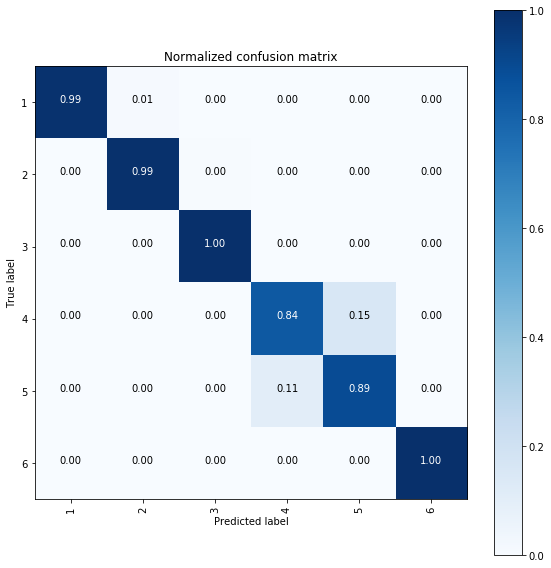

In [486]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=range(1,7), normalize=True, title='Normalized confusion matrix')
plt.show()
    

In [514]:
from prettytable import PrettyTable
x = PrettyTable()

In [515]:
x.field_names = ["models", "Test_auc"]
x.add_row(["model_single_LSTM", 0.92235])
x.add_row(["model_multi_layer_Lstm", 0.9288])
x.add_row(["model_dividmconquer_Lstm_cnn", 0.95147])
print(x)

+------------------------------+----------+
|            models            | Test_auc |
+------------------------------+----------+
|      model_single_LSTM       | 0.92235  |
|    model_multi_layer_Lstm    |  0.9288  |
| model_dividmconquer_Lstm_cnn | 0.95147  |
+------------------------------+----------+
